In [38]:
# 导入pandas、numpy库
import numpy as np
import pandas as pd

In [39]:
# 数据集中每列元素名
names = (
    'age',
    'workclass',
    'fnlwgt',
    'education',
    'education-num',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'native-country',
    'income',
)

# 准标识符
qi_names = (
    'age',
    'workclass',
    'education',
    'marital-status',
    'occupation',
    'race',
    'sex',
    'native-country',
)

In [40]:
# 读取数据集
df = pd.read_csv("./adult.csv", names=names)
# 丢弃所有带？的行数据
df = df.replace('?', np.NAN).dropna()
df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50k
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50k
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50k
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50k
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50k
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48836,33,Private,245211,Bachelors,13,Never-married,Prof-specialty,Own-child,White,Male,0,0,40,United-States,<=50k
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50k
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50k
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50k


In [41]:
# 根据配置文件构造泛化树
class Tree:
    def __init__(self, confile):
        self.confile = confile
        self.nodes = {}
        self.level = 0
        self.build_tree()

    def build_tree(self):
        tree_df = pd.read_csv(self.confile, header=None)
        self.level = tree_df.shape[1] - 1
        for row in tree_df.itertuples():
            pre = None
            h = len(row) - 2
            for col in row[-1:0:-1]:
                self.nodes[str(col)] = (pre, h)
                pre = col
                h -= 1

In [47]:
# 为每个准标识符生成泛化树
gen_tree = {}
# 泛化级别
gen_level = {}

# 根据配置文件生成泛化树
conf_prefix = './conf/'
conf_suffix = '_hierarchy.csv'
for qi_name in qi_names:
    gen_tree[qi_name] = Tree(conf_prefix + qi_name + conf_suffix)
    gen_level[qi_name] = 0

list(gen_tree.values())[1].nodes, list(gen_tree.values())[1].level

({'*': (None, 2),
  '非政府工作': ('*', 1),
  'Private': ('非政府工作', 0),
  'Self-emp-not-inc': ('非政府工作', 0),
  'Self-emp-inc': ('非政府工作', 0),
  '政府工作': ('*', 1),
  'Federal-gov': ('政府工作', 0),
  'Local-gov': ('政府工作', 0),
  'State-gov': ('政府工作', 0),
  '无业': ('*', 1),
  'Without-pay': ('无业', 0),
  'Never-worked': ('无业', 0)},
 2)

In [43]:
# 找到最多不同值的准标识符
def max_qi(df):
    return df[list(qi_names)].nunique().idxmax()


# 统计 未K匿名的数据条数 和 数据重复频率
def freq(df, k):
    group_df = df[list(qi_names)].groupby(list(qi_names), as_index=False).size()
    return group_df[group_df['size'] < k]['size'].sum(), pd.merge(df, group_df, on=list(qi_names))


# 根据泛化树获得泛化后值
def generalize(value, qi):
    return gen_tree[qi].nodes[str(value)][0]


def cal_information_loss(gen_level, tree, qi_names):
    """
    根据泛化层级计算信息损失度
    :param gen_level: 当前泛化等级
    :param tree: 泛化树
    :param qi_names: 准标识符
    :return: 各准标识符泛化比例的平均值
    """
    return sum([gen_level[i] / tree[i].level for i in qi_names]) / len(qi_names)


# df[list(qi_names)].nunique()
# max_qi(df)
df[list(qi_names)].groupby(list(qi_names), as_index=False).size()
# freq(df,5)

,age,workclass,education,marital-status,occupation,race,sex,native-country,size
0,17,Federal-gov,11th,Never-married,Adm-clerical,Amer-Indian-Eskimo,Female,United-States,1
1,17,Federal-gov,11th,Never-married,Adm-clerical,Black,Female,United-States,1
2,17,Local-gov,10th,Never-married,Farming-fishing,White,Male,United-States,1
3,17,Local-gov,10th,Never-married,Other-service,White,Female,United-States,1
4,17,Local-gov,10th,Never-married,Prof-specialty,White,Female,United-States,1
...,...,...,...,...,...,...,...,...,...
24761,90,Self-emp-not-inc,Bachelors,Married-civ-spouse,Prof-specialty,White,Male,United-States,1
24762,90,Self-emp-not-inc,HS-grad,Never-married,Exec-managerial,White,Male,United-States,1
24763,90,Self-emp-not-inc,Prof-school,Married-civ-spouse,Prof-specialty,White,Male,United-States,1
24764,90,Self-emp-not-inc,Prof-school,Widowed,Prof-specialty,White,Male,United-States,1


In [44]:
# 初始信息损失度
cal_information_loss(gen_level, gen_tree, qi_names)

0.0

In [45]:
import time

# 拷贝一个缓存
tmp = df.copy(deep=True)
# 泛化总论次、每次泛化信息损失、每次泛化未K匿名的数据总数
rounds = 0
round_loss = []
round_unk_count = []

# 设置 k 值
k = 5

start = time.time()
while True:
    count, freq_df = freq(tmp, k)

    # 记录每轮泛化前相关数据
    round_loss.append(cal_information_loss(gen_level, gen_tree, qi_names))
    round_unk_count.append(count)
    rounds += 1

    if count > k:
        # 获得最大不同值的准标识符
        mqi = max_qi(tmp)
        # 根据对应的泛化树泛化该准标识符
        tmp[mqi] = tmp[mqi].apply(generalize, qi=mqi)
        # 该准标识符泛化等级加一
        gen_level[mqi] += 1
    else:
        # 删除未K匿名化的数据
        tmp = freq_df[freq_df['size'] >= k]
        break
print(f"泛化{rounds - 1}轮 耗时{time.time() - start}s")

泛化22轮 耗时4.146989822387695s


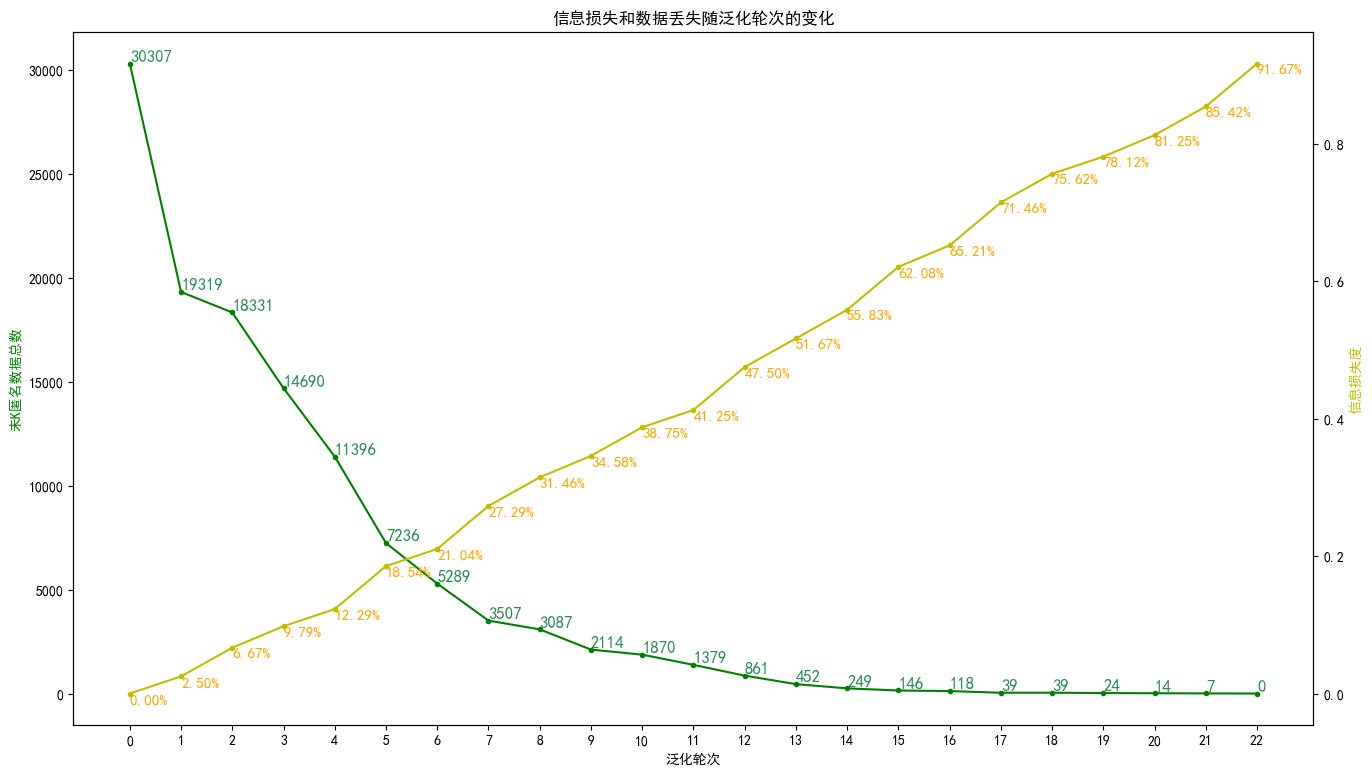

In [46]:
import matplotlib.pyplot as plt
from pylab import xticks, np

# 绘制双Y轴折线图
x = np.arange(rounds)

plt.rcParams['font.sans-serif'] = ['SimHei']  # 显示汉字
plt.rcParams['figure.figsize'] = (16, 9)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(x, round_unk_count, 'g', marker='o', markersize=3)
ax2.plot(x, round_loss, 'y', marker='o', markersize=3)

ax1.set_xlabel('泛化轮次')
ax1.set_ylabel('未K匿名数据总数', color='g')
ax2.set_ylabel('信息损失度', color='y')

xticks_labels = [f'{i}' for i in range(0, rounds)]
xticks(np.linspace(0, rounds - 1, rounds, endpoint=True), xticks_labels)
for i in range(rounds):
    ax1.text(x[i], round_unk_count[i] + 100, f"{round_unk_count[i]}", fontsize=12, color='seagreen')
    ax2.text(x[i], round_loss[i] - 0.015, f"{round_loss[i] * 100:.2f}%", fontsize=11, color='orange')
plt.title('信息损失和数据丢失随泛化轮次的变化')
plt.show()